In [6]:
import numpy as np
import matplotlib.pyplot as plt


# We define a function to run the simulation for a given T_max
# and return the final gas cost.
def run_simulation(T_max,V_buffer,P_boiler,plots_show=False,sim_hours=128):
    dt = 60  # time step in seconds
    num_steps = int(sim_hours * 3600 // dt)
    time = np.linspace(0, sim_hours, num_steps)  # time in hours

    # Environment and system parameters
    T_amb_day = 18  # ambient temperature during the day in °C
    T_amb_night = 10  # ambient temperature at night in °C
    T_min = 50       # lower hysteresis limit for turning on
    T_init = 50      # initial buffer temperature in °C

    # Buffer specifications
    V = V_buffer       # volume of the buffer tank in m³ (e.g. 2000 liters)
    rho = 1000         # density of water (kg/m³)
    m = V * rho        # mass of the water (kg)
    c_p = 4200         # specific heat capacity of water (J/(kg*K))

    # Boiler parameters
    P_boiler = P_boiler    # power of the boiler in Watts
    eta = 0.9          # efficiency of the boiler

    # Heat demand with daily peaks in the morning and evening
    time_mod24 = (time % 24)
    P_load = 300 + 500 * (np.sin((time_mod24 - 6) * np.pi / 6) > 0) \
                 + 500 * (np.sin((time_mod24 - 18) * np.pi / 6) > 0)

    # Heat loss coefficient
    k = 10             # W/K

    # Variable price per kWh of gas
    price_per_kWh_base = 0.06
    price_per_kWh = price_per_kWh_base \
                    + 0.02 * (np.sin((time_mod24 - 6) * np.pi / 6) > 0) \
                    + 0.02 * (np.sin((time_mod24 - 18) * np.pi / 6) > 0)

    # Arrays for simulation output
    T = np.zeros(num_steps)
    T[0] = T_init
    gas_energy_consumed = np.zeros(num_steps)  # in Joules
    gas_cost = np.zeros(num_steps)
    boiler_on = np.zeros(num_steps, dtype=bool)

    # Euler integration
    for i in range(1, num_steps):
        # Determine ambient temperature (day/night cycle)
        hour_in_day = time[i] % 24
        T_amb = T_amb_day if (6 <= hour_in_day < 22) else T_amb_night

        # Hysteresis control for the boiler
        if T[i-1] < T_min:
            on = True
        elif T[i-1] >= T_max:
            on = False
        else:
            on = boiler_on[i-1]
        boiler_on[i] = on

        # Heating power if the boiler is on
        P_heating = P_boiler if on else 0

        # Heat loss (Newton's law)
        P_loss = k * (T[i-1] - T_amb)

        # Update temperature
        dT = (P_heating - P_load[i] - P_loss) * dt / (m * c_p)
        T[i] = T[i-1] + dT

        # Calculate gas consumption (in Joules) taking into account efficiency
        gas_energy_consumed[i] = gas_energy_consumed[i-1] + (P_heating / eta) * dt

        # Cumulative gas cost (euro) with variable price
        gas_cost[i] = gas_cost[i-1] \
                      + (P_heating / eta) * dt / 3.6e6 * price_per_kWh[i]
    
    if plots_show:
        # Zet gasenergie om naar kWh (1 kWh = 3.6e6 Joules)
        gas_energy_kWh = gas_energy_consumed / 3.6e6
        
        # Plot de resultaten
        fig, axs = plt.subplots(5, 1, figsize=(10, 20))
        
        axs[0].plot(time, T)
        axs[0].set_xlabel("Tijd (uren)")
        axs[0].set_ylabel("Temperatuur (°C)")
        axs[0].set_title("Temperatuur in het Buffervat")
        axs[0].grid(True)
        
        axs[1].plot(time, gas_energy_kWh)
        axs[1].set_xlabel("Tijd (uren)")
        axs[1].set_ylabel("Gasverbruik (kWh)")
        axs[1].set_title("Cumulatief Gasverbruik")
        axs[1].grid(True)
    
        axs[2].plot(time, gas_cost)
        axs[2].set_xlabel("Tijd (uren)")
        axs[2].set_ylabel("Kosten (€)")
        axs[2].set_title("Cumulatieve Gas Kosten")
        axs[2].grid(True)
    
        axs[3].plot(time, P_load)
        axs[3].set_xlabel("Tijd (uren)")
        axs[3].set_ylabel("Warmtevraag (W)")
        axs[3].set_title("Warmtevraag van de Afnemer")
        axs[3].grid(True)
    
        axs[4].plot(time, price_per_kWh)
        axs[4].set_xlabel("Tijd (uren)")
        axs[4].set_ylabel("Prijs (€/kWh)")
        axs[4].set_title("Variabele Gasprijs Over Tijd")
        axs[4].grid(True)
    
        plt.tight_layout()
        plt.show()
    # Return final gas cost
    return gas_cost[-1]

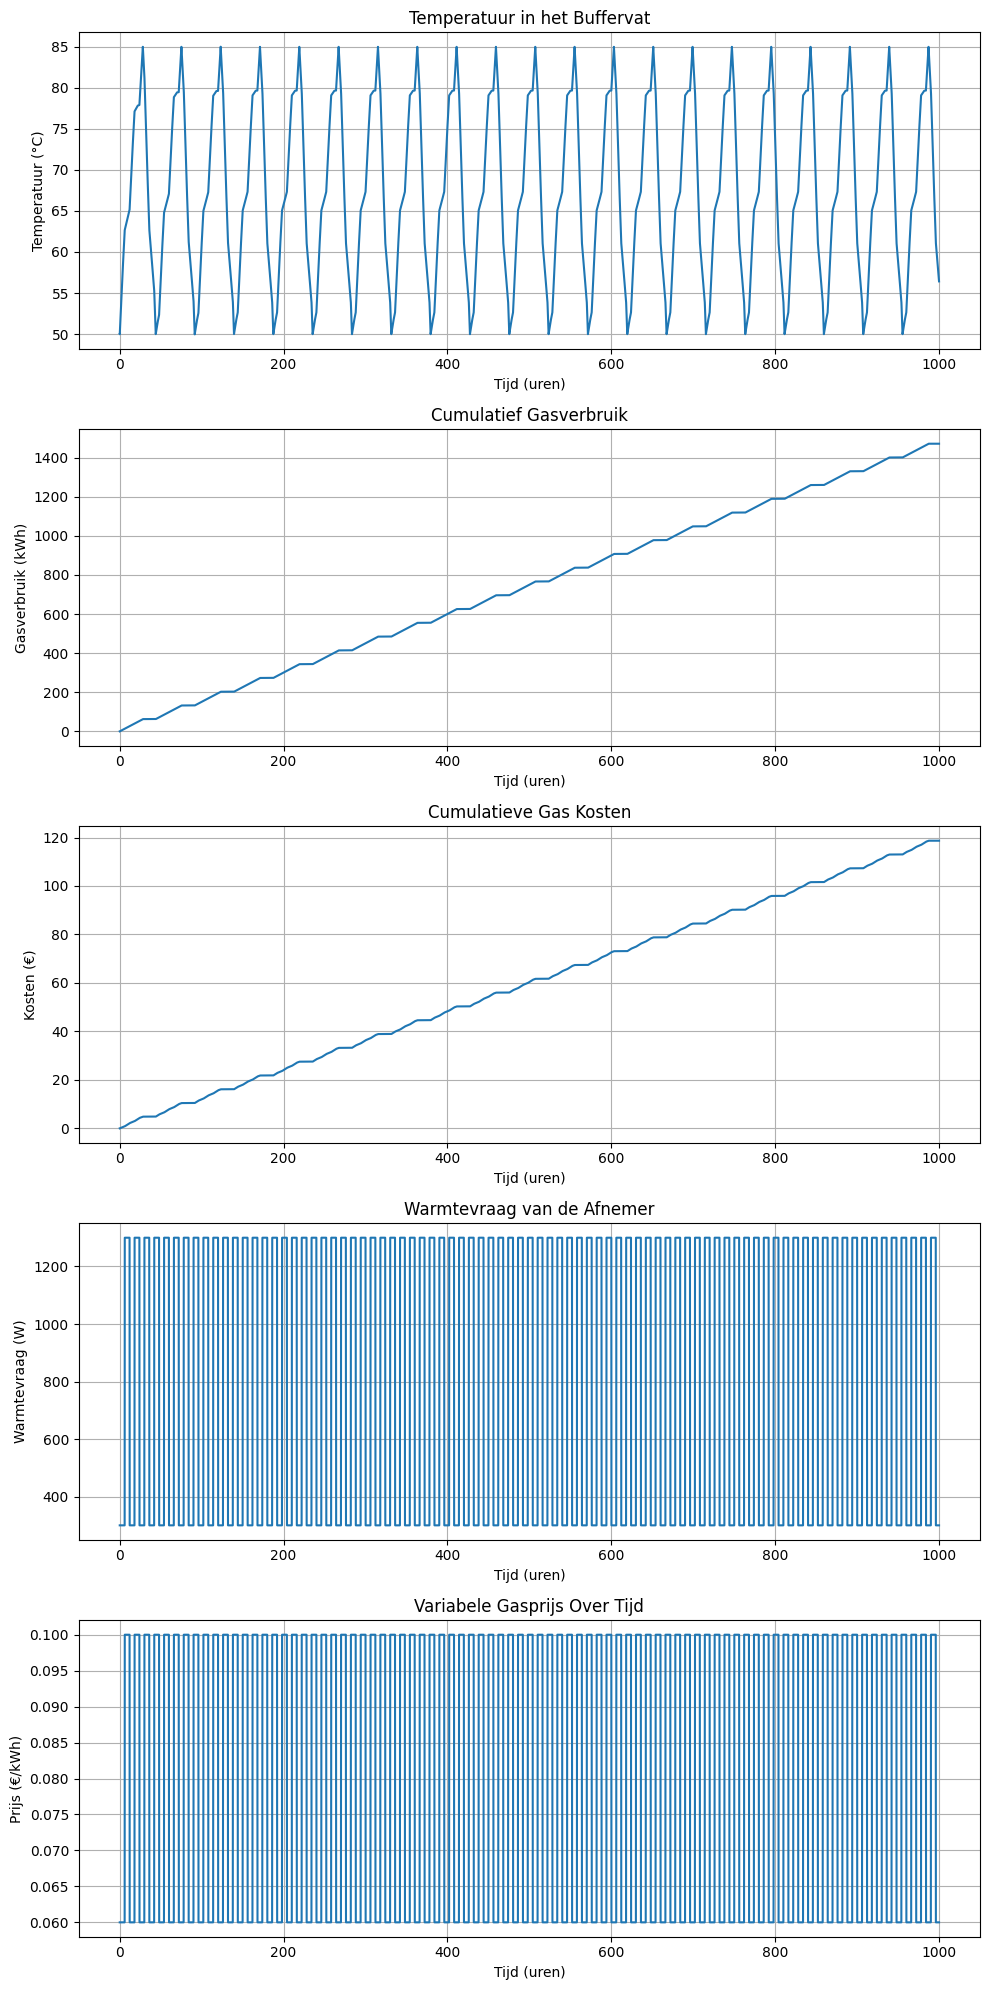

np.float64(118.68296296294932)

In [10]:
run_simulation(T_max=85,V_buffer=0.5,P_boiler=2000,sim_hours=1000,plots_show=True)

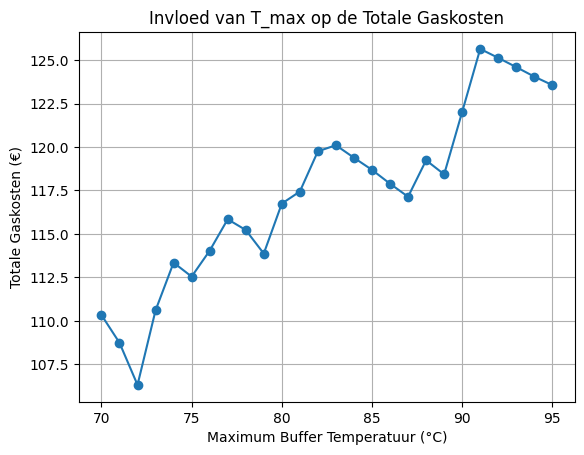

In [9]:
# Now we sweep T_max from 70 to 95 (inclusive) and store the final gas cost.
t_max_values = range(70, 96)
final_costs = []

for tmax in t_max_values:
    cost = run_simulation(tmax,V_buffer=0.5,P_boiler=2000,sim_hours=1000)
    final_costs.append(cost)

# Plot the final gas cost vs. T_max
plt.figure()
plt.plot(t_max_values, final_costs, marker='o')
plt.xlabel("Maximum Buffer Temperatuur (°C)")
plt.ylabel("Totale Gaskosten (€)")
plt.title("Invloed van T_max op de Totale Gaskosten")
plt.grid(True)
plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation_smart(
    T_max,
    V_buffer,
    P_boiler,
    sim_hours=128,
    plots_show=True,
    T_min=50,            # Normale ondergrens voor hysterese
    T_emergency=40,      # Buffer is 'bijna leeg/koud' onder deze temperatuur
    price_threshold=0.08 # Bovengrens waarboven we zeggen: te duur om te stoken
):
    """
    Run een simulatie met 'slimme' regeling:
      - als de buffer < T_emergency is, MOET de ketel aan
      - als de gasprijs > price_threshold is, gaat de ketel uit
        (tenzij buffer < T_emergency)
      - anders (prijs niet hoog, buffer niet leeg) gebruik normale hysterese (T_min <-> T_max)
    """
    
    dt = 60  # tijdsstap in seconden
    num_steps = int(sim_hours * 3600 // dt)
    time = np.linspace(0, sim_hours, num_steps)  # tijd in uren

    # Dag/nacht-temperaturen
    T_amb_day = 18   
    T_amb_night = 10

    # Beginwaarden
    T_init = 50  # start-buffertemperatuur in °C

    # Buffergegevens
    V = V_buffer  # volume in m³
    rho = 1000    # kg/m³
    m = V * rho   # massa water (kg)
    c_p = 4200    # J/(kg*K)

    # Ketelparameters
    P_boiler = P_boiler  # vermogen in W
    eta = 0.9            # rendement

    # Bereken tijd modulo 24 voor dagelijkse variaties
    time_mod24 = time % 24

    # Warmtevraag (nu geleidelijk variërend)
    P_load = (
        300
        + 500 * ((np.sin((time_mod24 - 6) * np.pi / 6) + 1)/2)
        + 500 * ((np.sin((time_mod24 - 18) * np.pi / 6) + 1)/2)
    )

    # Gasprijs (nu geleidelijk variërend)
    base_price = 0.06
    price_per_kWh = (
        base_price
        + 0.02 * ((np.sin((time_mod24 - 6) * np.pi / 6) + 1)/2)
        + 0.02 * ((np.sin((time_mod24 - 18) * np.pi / 6) + 1)/2)
    )

    # Warmteverliescoëfficiënt (Newton)
    k = 10  # W/K

    # Arrays voor output
    T = np.zeros(num_steps)
    T[0] = T_init
    gas_energy_consumed = np.zeros(num_steps)  # Joules
    gas_cost = np.zeros(num_steps)
    boiler_on = np.zeros(num_steps, dtype=bool)

    for i in range(1, num_steps):
        # Bepaal de omgevingstemperatuur afhankelijk van het uur
        hour_in_day = time[i] % 24
        if 6 <= hour_in_day < 22:
            T_amb = T_amb_day
        else:
            T_amb = T_amb_night

        # -- Beslissingslogica voor de ketel --
        # 1) Als T < T_emergency -> altijd aan
        # 2) Anders, als prijs > price_threshold -> altijd uit
        # 3) Anders -> gewone hysterese op T_min / T_max
        if T[i-1] < T_emergency:
            on = True
        elif price_per_kWh[i] > price_threshold:
            on = False
        else:
            # normale hysterese
            if T[i-1] < T_min:
                on = True
            elif T[i-1] >= T_max:
                on = False
            else:
                on = boiler_on[i-1]

        boiler_on[i] = on

        # Verwarmingsvermogen
        P_heating = P_boiler if on else 0

        # Warmteverlies
        P_loss = k * (T[i-1] - T_amb)

        # Temperatuurupdate
        dT = (P_heating - P_load[i] - P_loss) * dt / (m * c_p)
        T[i] = T[i-1] + dT

        # Gasverbruik (in Joules)
        gas_energy_consumed[i] = gas_energy_consumed[i-1] + (P_heating / eta) * dt

        # Gaskosten (cumulatief)
        gas_cost[i] = gas_cost[i-1] + (P_heating / eta) * dt / 3.6e6 * price_per_kWh[i]

    # Plotten?
    if plots_show:
        gas_energy_kWh = gas_energy_consumed / 3.6e6

        fig, axs = plt.subplots(6, 1, figsize=(10, 24))
        
        axs[0].plot(time, T)
        axs[0].set_title("Temperatuur in Buffervat")
        axs[0].set_xlabel("Tijd (uur)")
        axs[0].set_ylabel("T (°C)")
        axs[0].grid(True)
        
        axs[1].plot(time, gas_energy_kWh)
        axs[1].set_title("Cumulatief Gasverbruik")
        axs[1].set_xlabel("Tijd (uur)")
        axs[1].set_ylabel("kWh")
        axs[1].grid(True)
        
        axs[2].plot(time, gas_cost)
        axs[2].set_title("Cumulatieve Gaskosten")
        axs[2].set_xlabel("Tijd (uur)")
        axs[2].set_ylabel("€")
        axs[2].grid(True)

        axs[3].plot(time, P_load)
        axs[3].set_title("Warmtevraag (P_load)")
        axs[3].set_xlabel("Tijd (uur)")
        axs[3].set_ylabel("W")
        axs[3].grid(True)

        axs[4].plot(time, price_per_kWh)
        axs[4].set_title("Gasprijs (variabel)")
        axs[4].set_xlabel("Tijd (uur)")
        axs[4].set_ylabel("€/kWh")
        axs[4].grid(True)

        axs[5].plot(time, boiler_on.astype(int))
        axs[5].set_title("Ketelstatus (1 = aan, 0 = uit)")
        axs[5].set_xlabel("Tijd (uur)")
        axs[5].set_ylabel("aan/uit")
        axs[5].grid(True)

        plt.tight_layout()
        plt.show()

    return gas_cost[-1]


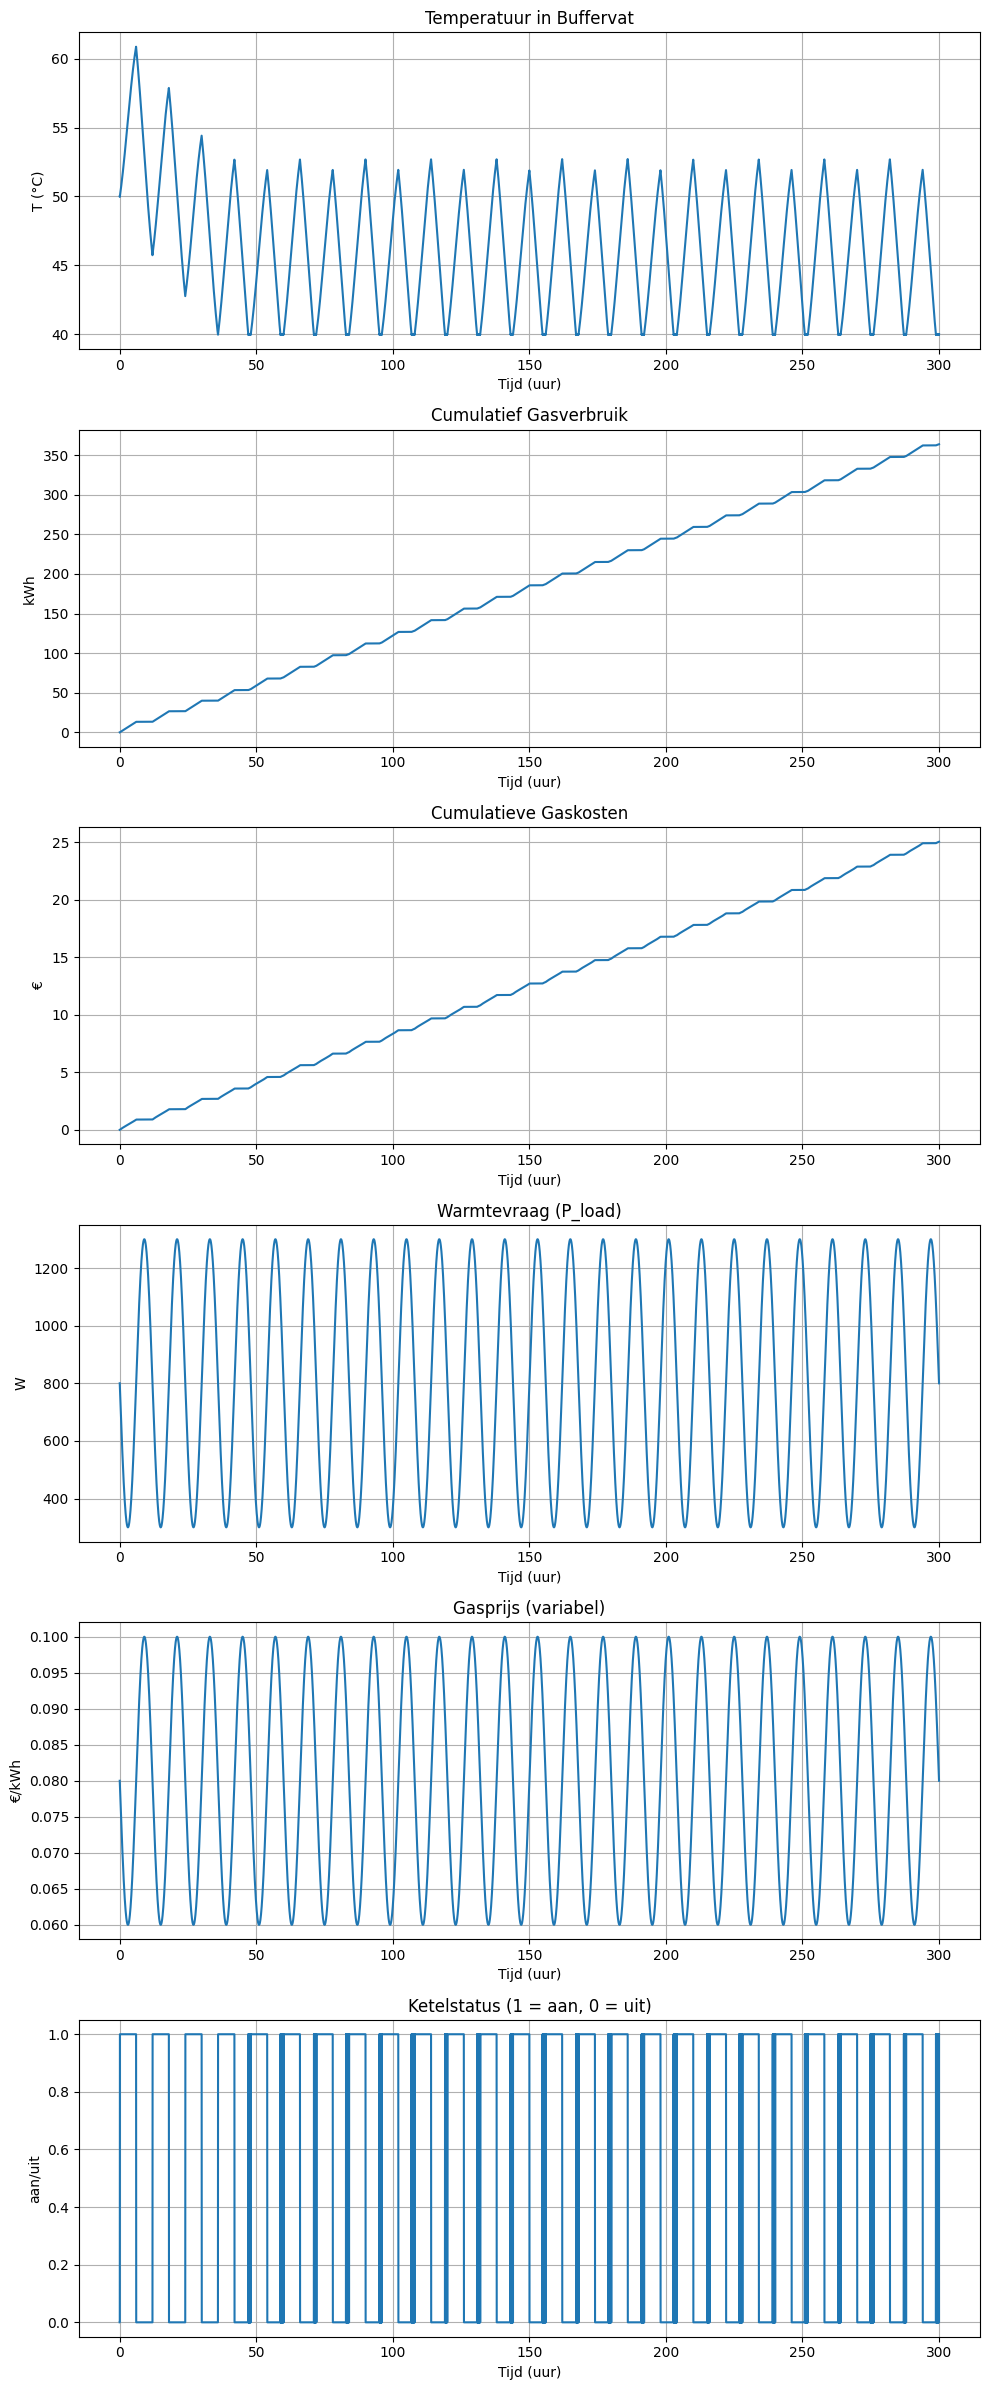

Totale gaskosten na 300 uur met 'slimme' regeling: €25.03


In [20]:
# Voorbeeld: simulatie 300 uur

final_cost_smart = run_simulation_smart(
    T_max=85,
    V_buffer=0.5,       # 500 liter
    P_boiler=2000,      # 2 kW ketel
    sim_hours=300,
    plots_show=True,
    T_min=50,           # Normale hysterese-bodem
    T_emergency=40,     # Onder 40 °C móet de ketel aan (ook bij dure gasprijs)
    price_threshold=0.08# Als prijs > 0.08 €/kWh => te hoog, tenzij T < 40
)

print(f"Totale gaskosten na 300 uur met 'slimme' regeling: €{final_cost_smart:.2f}")


In [22]:
# Now we sweep T_max from 70 to 95 (inclusive) and store the final gas cost.
price_treshold_list = np.linspace(0.01, 0.12, 20)
final_costs = []

for price_treshold in price_treshold_list:
    cost = final_cost_smart = run_simulation_smart(
    T_max=85,
    V_buffer=0.5,       # 500 liter
    P_boiler=2000,      # 2 kW ketel
    sim_hours=300,
    plots_show=False,
    T_min=50,           # Normale hysterese-bodem
    T_emergency=40,     # Onder 40 °C móet de ketel aan (ook bij dure gasprijs)
    price_threshold=price_treshold # Als prijs > 0.08 €/kWh => te hoog, tenzij T < 40
)
    final_costs.append(cost)

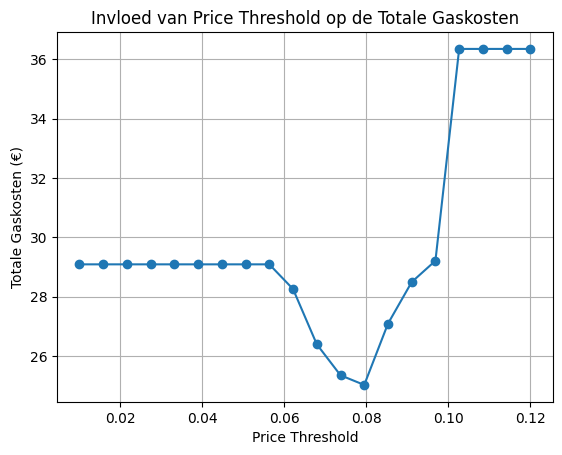

In [23]:
# Plot the final gas cost vs. T_max
plt.figure()
plt.plot(price_treshold_list, final_costs, marker='o')
plt.xlabel("Price Threshold")
plt.ylabel("Totale Gaskosten (€)")
plt.title("Invloed van Price Threshold op de Totale Gaskosten")
plt.grid(True)
plt.show()

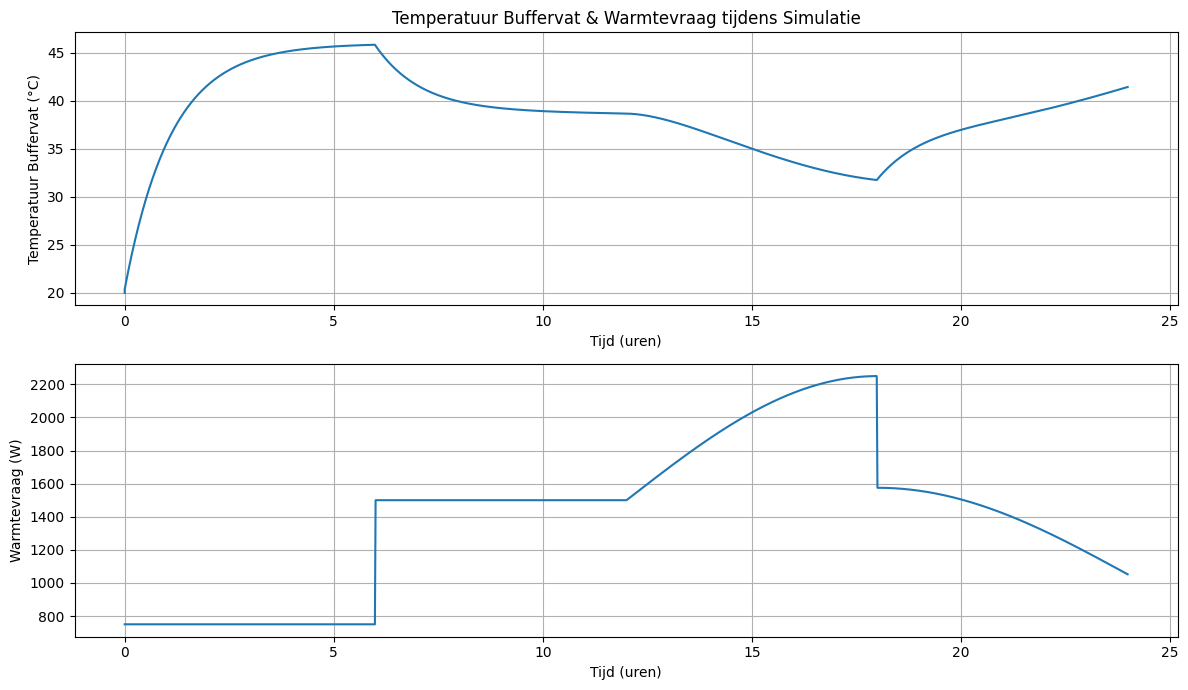

Simulatie voltooid.
Geschatte energiekosten voor 24 uur: €13.19


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Definieer de formules als functies (ongewijzigd)
def opslag_warmte(m, cp, delta_T):
    return m * cp * delta_T

def warmteverlies(k, T_buffer, T_omgeving):
    return k * (T_buffer - T_omgeving)

def temperatuur_dynamica(T_buffer, P_in, P_verlies, P_afnemer, m, cp, dt):
    dT_dt = (P_in - P_verlies - P_afnemer) / (m * cp)
    T_buffer_nieuw = T_buffer + dT_dt * dt
    return T_buffer_nieuw

def kosten_berekening(E_verbruik, rendement, prijs_per_kWh):
    return (E_verbruik / rendement) * prijs_per_kWh

# 2. Definieer parameters en constanten (aangepast - warmtevraag profiel toegevoegd)
massa_water = 100  # kg
cp_water = 4186   # J/kg°C
k_verlies = 5      # W/°C
T_omgeving_gemiddeld = 10    # °C, Gemiddelde omgevingstemperatuur
T_buffer_initieel = 20 # °C
P_ketel_max = 20000 # W
rendement_ketel = 0.9
prijs_per_kWh = 0.30 # €/kWh
T_gewenst_buffer = 55 # °C, Gewenste temperatuur in buffervat

dt = 60             # seconden (1 minuut)
simulatie_tijd = 3600 * 24 # seconden (24 uur)
tijd = 0
T_buffer_waarden = [T_buffer_initieel]
tijd_waarden = [0]
E_verbruik_waarden = [0] # Lijst om energieverbruik per tijdstap op te slaan

# --- Nieuw: Variabele Warmtevraag Profiel ---
def warmtevraag_profiel(tijd_uur, T_omgeving_actueel, T_omgeving_gemiddeld):
    """
    Genereert een voorbeeld warmtevraag profiel, afhankelijk van de tijd van de dag en de omgevingstemperatuur.
    Dit is een VEREENVOUDIGD voorbeeld, in de praktijk is de warmtevraag complexer.
    """
    dag_profiel = [0.5] * 6 + [1] * 12 + [0.7] * 6 # Lager 's nachts, hoger overdag (voorbeeld)
    uur_index = int(tijd_uur) % 24
    basis_vraag_factor = dag_profiel[uur_index]

    # Warmtevraag neemt toe als de omgevingstemperatuur daalt
    temperatuur_factor = 1 + max(0, (T_omgeving_gemiddeld - T_omgeving_actueel) / 10) # Elke 10°C lager, vraag +10% (voorbeeld)

    P_afnemer_basis = 1500 # W, Basis warmtevraag niveau
    P_afnemer = P_afnemer_basis * basis_vraag_factor * temperatuur_factor
    return max(100, P_afnemer) # Minimum warmtevraag om onrealistische 0 waarden te voorkomen


# 3. Simulatie loop (aangepast - Modulerende ketel & Verbeterde Kostenberekening)
T_buffer = T_buffer_initieel
E_verbruik_totaal = 0 # Voor verbeterde kostenberekening

while tijd < simulatie_tijd:
    tijd_uur = tijd / 3600
    T_omgeving_actueel = T_omgeving_gemiddeld + 5 * np.sin(2 * np.pi * tijd_uur / 24) # Voorbeeld: Omgevingstemp. schommelt dagelijks

    # --- Nieuw: Variabele Warmtevraag ---
    P_afnemer = warmtevraag_profiel(tijd_uur, T_omgeving_actueel, T_omgeving_gemiddeld)


    # --- Nieuw: Vereenvoudigde Modulerende Ketel ---
    temperatuur_verschil = T_gewenst_buffer - T_buffer
    P_in_onbegrensd = temperatuur_verschil * 100 # Lineaire regeling, factor 100 is voorbeeld, afhankelijk van systeem
    P_in = np.clip(P_in_onbegrensd, 0, P_ketel_max * rendement_ketel) # Begrens tot 0 en max ketelvermogen


    P_verlies = warmteverlies(k_verlies, T_buffer, T_omgeving_actueel)

    # Dynamica van de temperatuur
    T_buffer = temperatuur_dynamica(T_buffer, P_in, P_verlies, P_afnemer, massa_water, cp_water, dt)

    # --- Nieuw: Verbeterde Kostenberekening ---
    E_verbruik_stap = P_in * dt / 3600000 # Energieverbruik in kWh tijdens deze tijdstap
    E_verbruik_totaal += E_verbruik_stap
    E_verbruik_waarden.append(E_verbruik_stap) # Opslaan voor analyse (optioneel)


    # Opslaan van waarden voor grafiek
    T_buffer_waarden.append(T_buffer)
    tijd_waarden.append(tijd/3600)

    # Tijd bijwerken
    tijd += dt

# 4. Kostenberekening (verbeterd - gebruikt E_verbruik_totaal)
kosten_simulatie = kosten_berekening(E_verbruik_totaal, rendement_ketel, prijs_per_kWh)


# 5. Visualisatie van de resultaten
plt.figure(figsize=(12, 7)) # Groter figuur voor meer ruimte
plt.subplot(2, 1, 1) # Twee subplots onder elkaar
plt.plot(tijd_waarden, T_buffer_waarden)
plt.xlabel("Tijd (uren)")
plt.ylabel("Temperatuur Buffervat (°C)")
plt.title("Temperatuur Buffervat & Warmtevraag tijdens Simulatie")
plt.grid(True)

plt.subplot(2, 1, 2) # Tweede subplot voor warmtevraag
P_afnemer_waarden = [warmtevraag_profiel(tijd_waarden[i], T_omgeving_gemiddeld + 5 * np.sin(2 * np.pi * tijd_waarden[i] / 24) , T_omgeving_gemiddeld) for i in range(len(tijd_waarden))] # Bereken warmtevraag waarden voor plot
plt.plot(tijd_waarden, P_afnemer_waarden) # Plot warmtevraag
plt.xlabel("Tijd (uren)")
plt.ylabel("Warmtevraag (W)")
plt.grid(True)


plt.tight_layout() # Zorgt voor betere spacing tussen subplots
plt.show()


print(f"Simulatie voltooid.")
print(f"Geschatte energiekosten voor 24 uur: €{kosten_simulatie:.2f}")

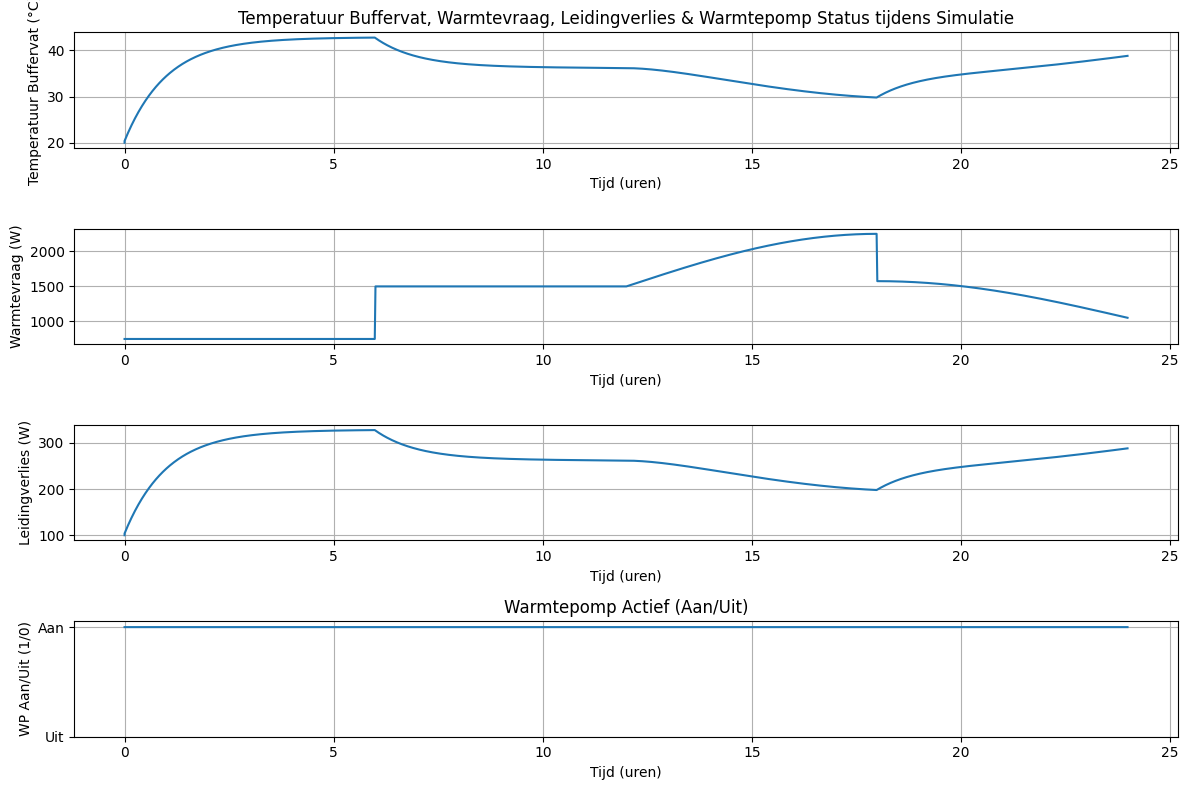

Simulatie voltooid (Warmtepomp, Leidingverlies & Aan/Uit Status).
Geschatte energiekosten voor 24 uur (warmtepomp): €3.77


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Definieer de formules als functies (aangepast met leidingverlies)
def opslag_warmte(m, cp, delta_T):
    return m * cp * delta_T

def warmteverlies(k, T_buffer, T_omgeving):
    return k * (T_buffer - T_omgeving)

def warmteverlies_leiding(k_leiding, lengte_leiding, T_buffer, T_omgeving_leiding): # Gebruiken T_buffer als benadering voor T_water_gemiddeld_leiding
    """
    Berekent het warmteverlies in de leidingen.
    P_leiding_verlies = k_leiding * lengte_leiding * (T_buffer - T_omgeving_leiding)
    """
    return k_leiding * lengte_leiding * (T_buffer - T_omgeving_leiding)


def temperatuur_dynamica(T_buffer, P_in, P_verlies_buffer, P_afnemer, P_verlies_leiding, m, cp, dt): # Let op: extra parameter P_verlies_leiding
    """
    Berekent de verandering van de temperatuur in het buffervat gedurende een tijdstap dt, MET leidingverlies.
    dT/dt = (P_in - P_verlies_buffer - P_afnemer - P_verlies_leiding) / (m * cp)
    """
    dT_dt = (P_in - P_verlies_buffer - P_afnemer - P_verlies_leiding) / (m * cp) # LET OP extra term - P_verlies_leiding
    T_buffer_nieuw = T_buffer + dT_dt * dt
    return T_buffer_nieuw

def kosten_berekening(E_verbruik, prijs_per_kWh): # Rendement is nu impliciet (COP warmtepomp)
    """
    Berekent de operationele kosten voor warmtepomp (elektriciteitsverbruik).
    Kosten = E_verbruik * Prijs per kWh (elektra)
    """
    return E_verbruik * prijs_per_kWh

# 2. Definieer parameters en constanten (aangepast voor warmtepomp EN leidingverlies)
massa_water = 100  # kg
cp_water = 4186   # J/kg°C
k_verlies = 5      # W/°C, warmteverliescoëfficiënt buffervat
T_omgeving_gemiddeld = 10    # °C, Gemiddelde omgevingstemperatuur
T_buffer_initieel = 20 # °C
P_warmtepomp_max = 20000 # W, Maximaal warmteafgifte vermogen van de warmtepomp (was P_ketel_max)
COP_warmtepomp_gemiddeld = 3.0 # Gemiddelde COP van de warmtepomp (voorbeeld)
P_elektrisch_WP_max = P_warmtepomp_max / COP_warmtepomp_gemiddeld # Geschat max elektrisch vermogen
prijs_per_kWh_elektra = 0.25 # €/kWh, prijs van elektriciteit (verschillend van gasprijs!)
T_gewenst_buffer = 55 # °C, Gewenste temperatuur in buffervat

k_leiding_verlies = 0.5      # W/m°C, Warmteverliescoëfficiënt leidingen (per meter, aanname!)
lengte_leidingen = 20        # m, Geschatte totale lengte van ongeïsoleerde leidingen
T_omgeving_leiding = T_omgeving_gemiddeld # Vereenvoudiging: omgevingstemp leidingen = gemiddelde omgevingstemp.

dt = 60             # seconden (1 minuut)
simulatie_tijd = 3600 * 24 # seconden (24 uur)
tijd = 0
T_buffer_waarden = [T_buffer_initieel]
tijd_waarden = [0]
E_verbruik_waarden = [0] # Lijst om energieverbruik per tijdstap op te slaan
WP_aan_waarden = [] # Lijst om 'Aan/Uit' status warmtepomp op te slaan


# --- Nieuw: Variabele Warmtevraag Profiel ---
def warmtevraag_profiel(tijd_uur, T_omgeving_actueel, T_omgeving_gemiddeld):
    """
    Genereert een voorbeeld warmtevraag profiel, afhankelijk van de tijd van de dag en de omgevingstemperatuur.
    Dit is een VEREENVOUDIGD voorbeeld, in de praktijk is de warmtevraag complexer.
    """
    dag_profiel = [0.5] * 6 + [1] * 12 + [0.7] * 6 # Lager 's nachts, hoger overdag (voorbeeld)
    uur_index = int(tijd_uur) % 24
    basis_vraag_factor = dag_profiel[uur_index]

    # Warmtevraag neemt toe als de omgevingstemperatuur daalt
    temperatuur_factor = 1 + max(0, (T_omgeving_gemiddeld - T_omgeving_actueel) / 10) # Elke 10°C lager, vraag +10% (voorbeeld)

    P_afnemer_basis = 1500 # W, Basis warmtevraag niveau
    P_afnemer = P_afnemer_basis * basis_vraag_factor * temperatuur_factor
    return max(100, P_afnemer) # Minimum warmtevraag om onrealistische 0 waarden te voorkomen


# 3. Simulatie loop (aangepast - Modulerende Warmtepomp & Leidingverlies & Verbeterde Kostenberekening & WP Aan/Uit tracking)
T_buffer = T_buffer_initieel
E_verbruik_totaal = 0 # Voor verbeterde kostenberekening

while tijd < simulatie_tijd:
    tijd_uur = tijd / 3600
    T_omgeving_actueel = T_omgeving_gemiddeld + 5 * np.sin(2 * np.pi * tijd_uur / 24) # Voorbeeld: Omgevingstemp. schommelt dagelijks

    # --- Variabele Warmtevraag ---
    P_afnemer = warmtevraag_profiel(tijd_uur, T_omgeving_actueel, T_omgeving_gemiddeld)

    # --- Vereenvoudigde Modulerende Warmtepomp ---
    temperatuur_verschil = T_gewenst_buffer - T_buffer
    P_in_onbegrensd = temperatuur_verschil * 100 # Lineaire regeling, factor 100 is voorbeeld, afhankelijk van systeem
    P_in = np.clip(P_in_onbegrensd, 0, P_warmtepomp_max) # Begrens tot max WARMTE vermogen WP

    # --- Elektrisch vermogen warmtepomp berekenen voor kosten ---
    P_elektrisch_in = 0 # Initialisatie
    if P_in > 0:
        P_elektrisch_in = P_in / COP_warmtepomp_gemiddeld # Geschat elektrisch vermogen op basis van COP en geleverd warmtevermogen

    P_verlies_buffer = warmteverlies(k_verlies, T_buffer, T_omgeving_actueel)
    # --- Nieuw: Leidingverlies berekenen ---
    P_verlies_leiding = warmteverlies_leiding(k_leiding_verlies, lengte_leidingen, T_buffer, T_omgeving_leiding) # Gebruik T_buffer als benadering

    # Dynamica van de temperatuur (let op: nu met P_verlies_leiding)
    T_buffer = temperatuur_dynamica(T_buffer, P_in, P_verlies_buffer, P_afnemer, P_verlies_leiding, massa_water, cp_water, dt) # LET OP extra parameter P_verlies_leiding

    # --- Verbeterde Kostenberekening (aangepast voor warmtepomp - elektrisch verbruik) ---
    E_verbruik_stap = P_elektrisch_in * dt / 3600000 # NU: Elektrisch energieverbruik in kWh
    E_verbruik_totaal += E_verbruik_stap
    E_verbruik_waarden.append(E_verbruik_stap)

    # --- Nieuw: Bepaal 'Aan/Uit' status warmtepomp en opslaan ---
    if P_in > 0:
        WP_aan_status = 1  # Warmtepomp staat aan
    else:
        WP_aan_status = 0  # Warmtepomp staat uit
    WP_aan_waarden.append(WP_aan_status)


    # Opslaan van waarden voor grafiek
    T_buffer_waarden.append(T_buffer)
    tijd_waarden.append(tijd/3600)

    # Tijd bijwerken
    tijd += dt

# 4. Kostenberekening (verbeterd - gebruikt E_verbruik_totaal en elektra prijs)
kosten_simulatie = kosten_berekening(E_verbruik_totaal, prijs_per_kWh_elektra) # Rendement is impliciet in COP


# 5. Visualisatie van de resultaten
plt.figure(figsize=(12, 8)) # Nog iets groter figuur voor 4 subplots
plt.subplot(4, 1, 1) # Nu 4 subplots onder elkaar
plt.plot(tijd_waarden, T_buffer_waarden)
plt.xlabel("Tijd (uren)")
plt.ylabel("Temperatuur Buffervat (°C)")
plt.title("Temperatuur Buffervat, Warmtevraag, Leidingverlies & Warmtepomp Status tijdens Simulatie")
plt.grid(True)

plt.subplot(4, 1, 2) # Tweede subplot voor warmtevraag
P_afnemer_waarden = [warmtevraag_profiel(tijd_waarden[i], T_omgeving_gemiddeld + 5 * np.sin(2 * np.pi * tijd_waarden[i] / 24) , T_omgeving_gemiddeld) for i in range(len(tijd_waarden))] # Bereken warmtevraag waarden voor plot
plt.plot(tijd_waarden, P_afnemer_waarden) # Plot warmtevraag
plt.xlabel("Tijd (uren)")
plt.ylabel("Warmtevraag (W)")
plt.grid(True)

plt.subplot(4, 1, 3) # Derde subplot voor leidingverlies
P_leiding_verlies_waarden = [warmteverlies_leiding(k_leiding_verlies, lengte_leidingen, T_buffer_waarden[i], T_omgeving_leiding) for i in range(len(T_buffer_waarden))] # Bereken leidingverlies waarden voor plot
plt.plot(tijd_waarden, P_leiding_verlies_waarden) # Plot leidingverlies
plt.xlabel("Tijd (uren)")
plt.ylabel("Leidingverlies (W)")
plt.grid(True)

plt.subplot(4, 1, 4) # Vierde subplot voor warmtepomp 'Aan/Uit' status
plt.plot(tijd_waarden[1:], WP_aan_waarden) # 'steps-post' voor blokvormige weergave, tijd_waarden[1:] om lengte gelijk te houden
plt.xlabel("Tijd (uren)")
plt.ylabel("WP Aan/Uit (1/0)")
plt.yticks([0, 1], ['Uit', 'Aan']) # Y-as labels voor 'Aan' en 'Uit'
plt.title("Warmtepomp Actief (Aan/Uit)")
plt.grid(True)


plt.tight_layout()
plt.show()


print(f"Simulatie voltooid (Warmtepomp, Leidingverlies & Aan/Uit Status).")
print(f"Geschatte energiekosten voor 24 uur (warmtepomp): €{kosten_simulatie:.2f}")